# Deteksi Anomali MQTT Dataset menggunakan Isolation Forest

Notebook ini berisi implementasi sistem deteksi anomali pada dataset MQTT menggunakan algoritma Isolation Forest.

**Label Target:**
- `legitimate` → Normal (tidak anomali)
- `dos`, `malformed`, `slowite`, `bruteforce` → Anomali


## 1. Import Library


In [85]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score
)

# Dimensionality Reduction for Visualization
from sklearn.decomposition import PCA

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("✅ Library berhasil di-import!")


✅ Library berhasil di-import!


## 2. Load Dataset


In [86]:
# Load training dan testing dataset
train_df = pd.read_csv('dataset/raw/train70_cleaned.csv')
test_df = pd.read_csv('dataset/raw/test30_cleaned.csv')

print(f"📊 Training Dataset Shape: {train_df.shape}")
print(f"📊 Testing Dataset Shape: {test_df.shape}")
print(f"\n📋 Kolom Dataset ({len(train_df.columns)} kolom):")
print(train_df.columns.tolist())


📊 Training Dataset Shape: (231646, 34)
📊 Testing Dataset Shape: (99290, 34)

📋 Kolom Dataset (34 kolom):
['tcp.flags', 'tcp.time_delta', 'tcp.len', 'mqtt.conack.flags', 'mqtt.conack.flags.reserved', 'mqtt.conack.flags.sp', 'mqtt.conack.val', 'mqtt.conflag.cleansess', 'mqtt.conflag.passwd', 'mqtt.conflag.qos', 'mqtt.conflag.reserved', 'mqtt.conflag.retain', 'mqtt.conflag.uname', 'mqtt.conflag.willflag', 'mqtt.conflags', 'mqtt.dupflag', 'mqtt.hdrflags', 'mqtt.kalive', 'mqtt.len', 'mqtt.msg', 'mqtt.msgid', 'mqtt.msgtype', 'mqtt.proto_len', 'mqtt.protoname', 'mqtt.qos', 'mqtt.retain', 'mqtt.sub.qos', 'mqtt.suback.qos', 'mqtt.ver', 'mqtt.willmsg', 'mqtt.willmsg_len', 'mqtt.willtopic', 'mqtt.willtopic_len', 'target']


In [87]:
# Preview data training
print("🔍 Preview Training Data:")
train_df.head()


🔍 Preview Training Data:


,tcp.flags,tcp.time_delta,tcp.len,mqtt.conack.flags,mqtt.conack.flags.reserved,mqtt.conack.flags.sp,mqtt.conack.val,mqtt.conflag.cleansess,mqtt.conflag.passwd,mqtt.conflag.qos,...,mqtt.qos,mqtt.retain,mqtt.sub.qos,mqtt.suback.qos,mqtt.ver,mqtt.willmsg,mqtt.willmsg_len,mqtt.willtopic,mqtt.willtopic_len,target
0,0x00000018,0.998867,10,0,0,0,0.0,0,0,0,...,0,0,0,0,0.0,0,0,0,0,legitimate
1,0x00000010,0.000067,1460,0,0,0,0.0,0,0,0,...,1,0,0,0,0.0,0,0,0,0,dos
2,0x00000010,0.000058,1460,0,0,0,0.0,0,0,0,...,1,0,0,0,0.0,0,0,0,0,dos
3,0x00000018,0.000227,10,0,0,0,0.0,0,0,0,...,0,0,0,0,0.0,0,0,0,0,legitimate
4,0x00000018,0.000236,16,0,0,0,0.0,0,0,0,...,0,0,0,0,0.0,0,0,0,0,dos


In [88]:
# Informasi dataset
print("📈 Info Dataset Training:")
print(train_df.info())
print("\n" + "="*50)
print("\n📊 Distribusi Target (Training):")
print(train_df['target'].value_counts())
print("\n📊 Distribusi Target (Testing):")
print(test_df['target'].value_counts())


📈 Info Dataset Training:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231646 entries, 0 to 231645
Data columns (total 34 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   tcp.flags                   231646 non-null  object 
 1   tcp.time_delta              231646 non-null  float64
 2   tcp.len                     231646 non-null  int64  
 3   mqtt.conack.flags           231646 non-null  object 
 4   mqtt.conack.flags.reserved  231646 non-null  int64  
 5   mqtt.conack.flags.sp        231646 non-null  int64  
 6   mqtt.conack.val             231646 non-null  float64
 7   mqtt.conflag.cleansess      231646 non-null  int64  
 8   mqtt.conflag.passwd         231646 non-null  int64  
 9   mqtt.conflag.qos            231646 non-null  int64  
 10  mqtt.conflag.reserved       231646 non-null  int64  
 11  mqtt.conflag.retain         231646 non-null  int64  
 12  mqtt.conflag.uname          231646 non-null  in

## 3. Preprocessing


In [89]:
# Cek missing values
print("🔍 Missing Values (Training):")
print(train_df.isnull().sum().sum())
print("\n🔍 Missing Values (Testing):")
print(test_df.isnull().sum().sum())

# Cek tipe data non-numerik
print("\n📋 Kolom dengan tipe data object:")
object_cols = train_df.select_dtypes(include=['object']).columns.tolist()
print(object_cols)


🔍 Missing Values (Training):
0

🔍 Missing Values (Testing):
0

📋 Kolom dengan tipe data object:
['tcp.flags', 'mqtt.conack.flags', 'mqtt.conflags', 'mqtt.hdrflags', 'mqtt.msg', 'mqtt.protoname', 'target']


In [90]:
# Preprocessing: Encode kolom kategorikal dan pisahkan fitur dari target

# Simpan target asli untuk evaluasi nanti
y_train_original = train_df['target'].copy()
y_test_original = test_df['target'].copy()

# Buat label biner untuk Isolation Forest: legitimate=1 (normal), lainnya=-1 (anomaly)
y_train_binary = y_train_original.apply(lambda x: 1 if x == 'legitimate' else -1)
y_test_binary = y_test_original.apply(lambda x: 1 if x == 'legitimate' else -1)

print("📊 Distribusi Label Biner (Training):")
print(y_train_binary.value_counts())
print("\n📊 Distribusi Label Biner (Testing):")
print(y_test_binary.value_counts())


📊 Distribusi Label Biner (Training):
target
 1    115824
-1    115822
Name: count, dtype: int64

📊 Distribusi Label Biner (Testing):
target
-1    49651
 1    49639
Name: count, dtype: int64


In [91]:
# Pisahkan fitur (drop target dan kolom non-numerik)
# Kolom yang perlu di-drop atau di-encode
cols_to_drop = ['target']

# Identifikasi kolom object untuk encoding
X_train = train_df.drop(columns=cols_to_drop)
X_test = test_df.drop(columns=cols_to_drop)

# Encode kolom kategorikal (tcp.flags, mqtt.hdrflags, mqtt.protoname, dll)
label_encoders = {}
for col in X_train.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    # Fit pada gabungan train dan test untuk konsistensi
    combined = pd.concat([X_train[col], X_test[col]], axis=0).astype(str)
    le.fit(combined)
    X_train[col] = le.transform(X_train[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))
    label_encoders[col] = le

print(f"✅ Fitur setelah preprocessing: {X_train.shape[1]} kolom")
print(f"📋 Kolom fitur: {X_train.columns.tolist()}")


✅ Fitur setelah preprocessing: 33 kolom
📋 Kolom fitur: ['tcp.flags', 'tcp.time_delta', 'tcp.len', 'mqtt.conack.flags', 'mqtt.conack.flags.reserved', 'mqtt.conack.flags.sp', 'mqtt.conack.val', 'mqtt.conflag.cleansess', 'mqtt.conflag.passwd', 'mqtt.conflag.qos', 'mqtt.conflag.reserved', 'mqtt.conflag.retain', 'mqtt.conflag.uname', 'mqtt.conflag.willflag', 'mqtt.conflags', 'mqtt.dupflag', 'mqtt.hdrflags', 'mqtt.kalive', 'mqtt.len', 'mqtt.msg', 'mqtt.msgid', 'mqtt.msgtype', 'mqtt.proto_len', 'mqtt.protoname', 'mqtt.qos', 'mqtt.retain', 'mqtt.sub.qos', 'mqtt.suback.qos', 'mqtt.ver', 'mqtt.willmsg', 'mqtt.willmsg_len', 'mqtt.willtopic', 'mqtt.willtopic_len']


In [92]:
# Standardisasi fitur
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"✅ Data sudah di-scaling")
print(f"📊 X_train shape: {X_train_scaled.shape}")
print(f"📊 X_test shape: {X_test_scaled.shape}")


✅ Data sudah di-scaling
📊 X_train shape: (231646, 33)
📊 X_test shape: (99290, 33)


## 4. Exploratory Data Analysis (EDA)


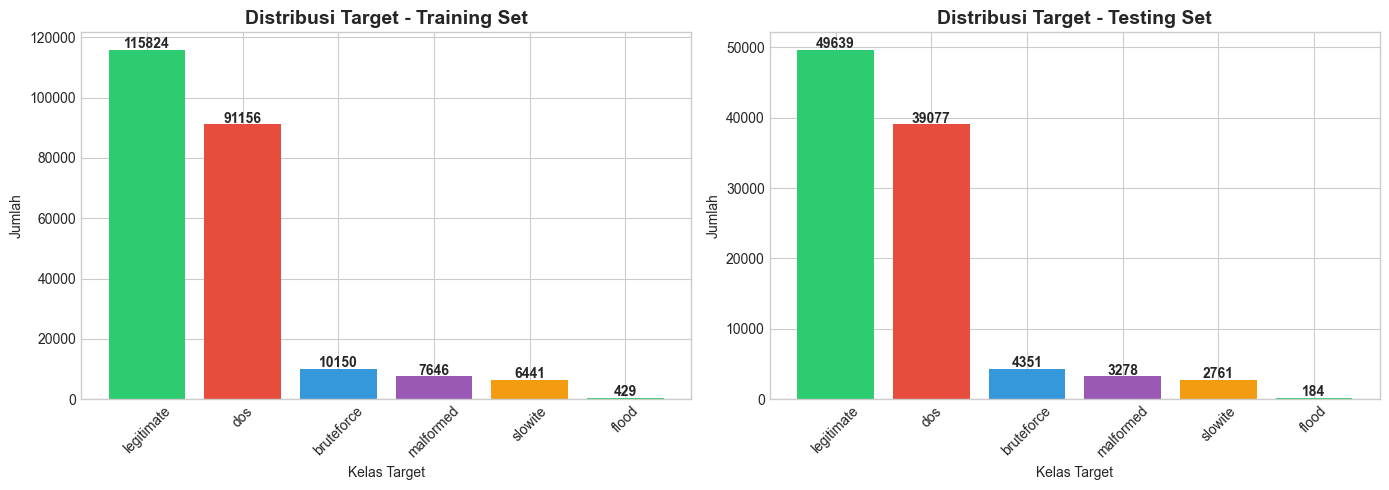

In [93]:
# EDA 1: Distribusi kelas target
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training set
colors = ['#2ecc71', '#e74c3c', '#3498db', '#9b59b6', '#f39c12']
train_counts = train_df['target'].value_counts()
axes[0].bar(train_counts.index, train_counts.values, color=colors[:len(train_counts)])
axes[0].set_title('Distribusi Target - Training Set', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Kelas Target')
axes[0].set_ylabel('Jumlah')
axes[0].tick_params(axis='x', rotation=45)
for i, v in enumerate(train_counts.values):
    axes[0].text(i, v + 500, str(v), ha='center', fontweight='bold')

# Testing set
test_counts = test_df['target'].value_counts()
axes[1].bar(test_counts.index, test_counts.values, color=colors[:len(test_counts)])
axes[1].set_title('Distribusi Target - Testing Set', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Kelas Target')
axes[1].set_ylabel('Jumlah')
axes[1].tick_params(axis='x', rotation=45)
for i, v in enumerate(test_counts.values):
    axes[1].text(i, v + 200, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


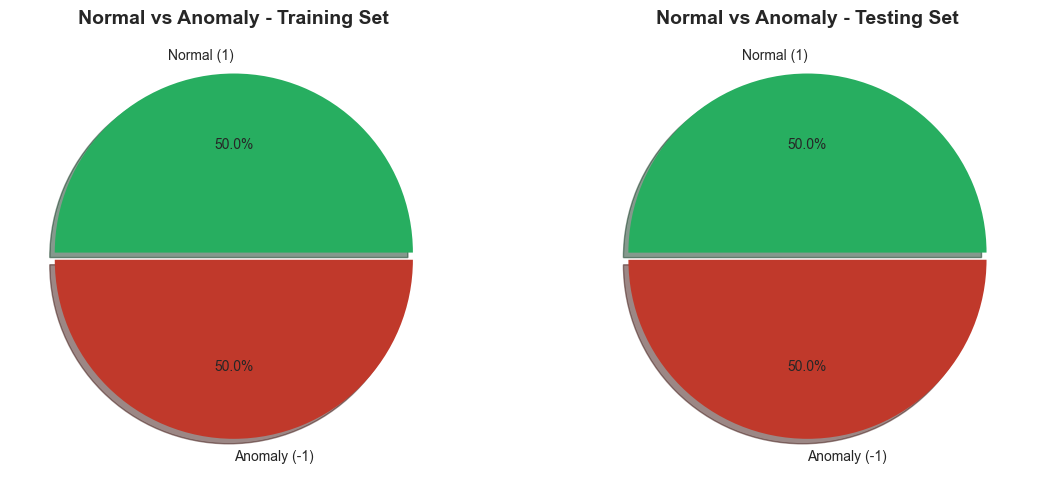


📊 Rasio Normal:Anomaly (Training) = 115824:115822
📊 Rasio Normal:Anomaly (Testing) = 49639:49651


In [94]:
# EDA 2: Distribusi Normal vs Anomaly (Binary)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Training
train_binary_counts = y_train_binary.value_counts()
labels = ['Normal (1)', 'Anomaly (-1)']
colors_binary = ['#27ae60', '#c0392b']
axes[0].pie(train_binary_counts.values, labels=labels, autopct='%1.1f%%', 
            colors=colors_binary, explode=(0.02, 0.02), shadow=True)
axes[0].set_title('Normal vs Anomaly - Training Set', fontsize=14, fontweight='bold')

# Testing
test_binary_counts = y_test_binary.value_counts()
axes[1].pie(test_binary_counts.values, labels=labels, autopct='%1.1f%%',
            colors=colors_binary, explode=(0.02, 0.02), shadow=True)
axes[1].set_title('Normal vs Anomaly - Testing Set', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n📊 Rasio Normal:Anomaly (Training) = {train_binary_counts[1]}:{train_binary_counts[-1]}")
print(f"📊 Rasio Normal:Anomaly (Testing) = {test_binary_counts[1]}:{test_binary_counts[-1]}")


## 5. Training Model Isolation Forest


In [95]:
# Hitung contamination rate berdasarkan proporsi anomali di training set
contamination_rate = (y_train_binary == -1).sum() / len(y_train_binary)
print(f"📊 Contamination Rate (proporsi anomali): {contamination_rate:.4f}")

# Inisialisasi dan training model Isolation Forest
iso_forest = IsolationForest(
    n_estimators=100,           # Jumlah pohon
    max_samples='auto',         # Jumlah sampel untuk setiap pohon
    contamination=contamination_rate,  # Proporsi anomali yang diharapkan
    random_state=42,
    n_jobs=-1,                  # Gunakan semua CPU
    verbose=0
)

# Training model
print("\n🔄 Training Isolation Forest...")
iso_forest.fit(X_train_scaled)
print("✅ Training selesai!")


📊 Contamination Rate (proporsi anomali): 0.5000

🔄 Training Isolation Forest...
✅ Training selesai!


## 6. Post-processing Hasil Prediksi (Label Anomali)


In [96]:
# Prediksi pada data training dan testing
# Isolation Forest output: 1 = normal, -1 = anomaly
y_train_pred = iso_forest.predict(X_train_scaled)
y_test_pred = iso_forest.predict(X_test_scaled)

# Dapatkan anomaly scores (semakin rendah = semakin anomali)
train_scores = iso_forest.decision_function(X_train_scaled)
test_scores = iso_forest.decision_function(X_test_scaled)

print("📊 Hasil Prediksi Training:")
print(f"   - Normal (1): {(y_train_pred == 1).sum()}")
print(f"   - Anomaly (-1): {(y_train_pred == -1).sum()}")

print("\n📊 Hasil Prediksi Testing:")
print(f"   - Normal (1): {(y_test_pred == 1).sum()}")
print(f"   - Anomaly (-1): {(y_test_pred == -1).sum()}")


📊 Hasil Prediksi Training:
   - Normal (1): 115832
   - Anomaly (-1): 115814

📊 Hasil Prediksi Testing:
   - Normal (1): 50009
   - Anomaly (-1): 49281


In [97]:
# Buat DataFrame hasil prediksi untuk analisis
results_df = pd.DataFrame({
    'target_asli': y_test_original,
    'label_biner_aktual': y_test_binary,
    'label_prediksi': y_test_pred,
    'anomaly_score': test_scores
})

# Mapping label untuk readability
results_df['prediksi_label'] = results_df['label_prediksi'].map({1: 'Normal', -1: 'Anomaly'})
results_df['aktual_label'] = results_df['label_biner_aktual'].map({1: 'Normal', -1: 'Anomaly'})

print("🔍 Sample Hasil Prediksi:")
results_df.head(10)


🔍 Sample Hasil Prediksi:


,target_asli,label_biner_aktual,label_prediksi,anomaly_score,prediksi_label,aktual_label
0,malformed,-1,-1,-0.075150,Anomaly,Anomaly
1,dos,-1,-1,-0.200603,Anomaly,Anomaly
2,legitimate,1,1,0.000000,Normal,Normal
3,malformed,-1,-1,-0.078224,Anomaly,Anomaly
4,dos,-1,1,0.029917,Normal,Anomaly
5,legitimate,1,1,0.042344,Normal,Normal
6,dos,-1,-1,-0.235664,Anomaly,Anomaly
7,dos,-1,-1,-0.219115,Anomaly,Anomaly
8,dos,-1,-1,-0.052607,Anomaly,Anomaly
9,legitimate,1,1,0.021719,Normal,Normal


## 7. Evaluasi Kinerja Model


In [98]:
# Evaluasi pada Testing Set
print("=" * 60)
print("📈 EVALUASI KINERJA MODEL - TESTING SET")
print("=" * 60)

# Hitung metrik
accuracy = accuracy_score(y_test_binary, y_test_pred)
precision = precision_score(y_test_binary, y_test_pred, pos_label=-1)  # Anomaly as positive
recall = recall_score(y_test_binary, y_test_pred, pos_label=-1)
f1 = f1_score(y_test_binary, y_test_pred, pos_label=-1)

print(f"\n🎯 Akurasi      : {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"🎯 Presisi      : {precision:.4f} ({precision*100:.2f}%)")
print(f"🎯 Recall       : {recall:.4f} ({recall*100:.2f}%)")
print(f"🎯 F1-Score     : {f1:.4f} ({f1*100:.2f}%)")


📈 EVALUASI KINERJA MODEL - TESTING SET

🎯 Akurasi      : 0.7415 (74.15%)
🎯 Presisi      : 0.7433 (74.33%)
🎯 Recall       : 0.7378 (73.78%)
🎯 F1-Score     : 0.7406 (74.06%)


In [99]:
# Classification Report
print("\n📋 Classification Report:")
print("-" * 60)
print(classification_report(y_test_binary, y_test_pred, 
                            target_names=['Anomaly (-1)', 'Normal (1)']))



📋 Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

Anomaly (-1)       0.74      0.74      0.74     49651
  Normal (1)       0.74      0.75      0.74     49639

    accuracy                           0.74     99290
   macro avg       0.74      0.74      0.74     99290
weighted avg       0.74      0.74      0.74     99290



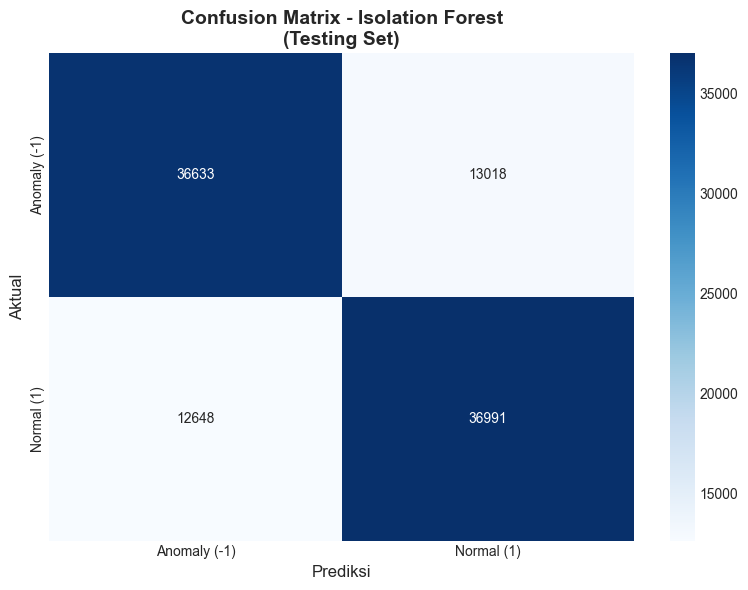


📊 Detail Confusion Matrix:
   - True Negative (TN)  : 36633 (Anomaly diprediksi Anomaly)
   - False Positive (FP) : 13018 (Anomaly diprediksi Normal)
   - False Negative (FN) : 12648 (Normal diprediksi Anomaly)
   - True Positive (TP)  : 36991 (Normal diprediksi Normal)


In [100]:
# Confusion Matrix Visualization
cm = confusion_matrix(y_test_binary, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Anomaly (-1)', 'Normal (1)'],
            yticklabels=['Anomaly (-1)', 'Normal (1)'])
plt.title('Confusion Matrix - Isolation Forest\n(Testing Set)', fontsize=14, fontweight='bold')
plt.xlabel('Prediksi', fontsize=12)
plt.ylabel('Aktual', fontsize=12)
plt.tight_layout()
plt.show()

# Detail confusion matrix
tn, fp, fn, tp = cm.ravel()
print(f"\n📊 Detail Confusion Matrix:")
print(f"   - True Negative (TN)  : {tn} (Anomaly diprediksi Anomaly)")
print(f"   - False Positive (FP) : {fp} (Anomaly diprediksi Normal)")
print(f"   - False Negative (FN) : {fn} (Normal diprediksi Anomaly)")
print(f"   - True Positive (TP)  : {tp} (Normal diprediksi Normal)")


## 8. Visualisasi Anomali


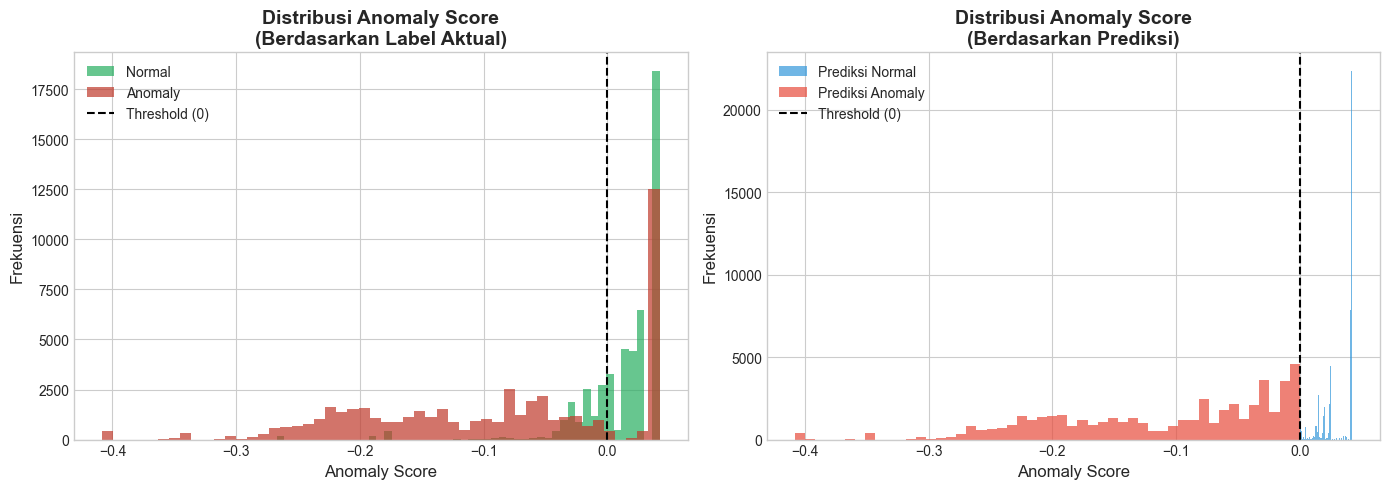

In [101]:
# Visualisasi 1: Distribusi Anomaly Score
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram anomaly score berdasarkan label aktual
axes[0].hist(test_scores[y_test_binary == 1], bins=50, alpha=0.7, label='Normal', color='#27ae60')
axes[0].hist(test_scores[y_test_binary == -1], bins=50, alpha=0.7, label='Anomaly', color='#c0392b')
axes[0].axvline(x=0, color='black', linestyle='--', label='Threshold (0)')
axes[0].set_xlabel('Anomaly Score', fontsize=12)
axes[0].set_ylabel('Frekuensi', fontsize=12)
axes[0].set_title('Distribusi Anomaly Score\n(Berdasarkan Label Aktual)', fontsize=14, fontweight='bold')
axes[0].legend()

# Histogram anomaly score berdasarkan prediksi
axes[1].hist(test_scores[y_test_pred == 1], bins=50, alpha=0.7, label='Prediksi Normal', color='#3498db')
axes[1].hist(test_scores[y_test_pred == -1], bins=50, alpha=0.7, label='Prediksi Anomaly', color='#e74c3c')
axes[1].axvline(x=0, color='black', linestyle='--', label='Threshold (0)')
axes[1].set_xlabel('Anomaly Score', fontsize=12)
axes[1].set_ylabel('Frekuensi', fontsize=12)
axes[1].set_title('Distribusi Anomaly Score\n(Berdasarkan Prediksi)', fontsize=14, fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.show()


📊 Variance explained by PCA: 49.74%


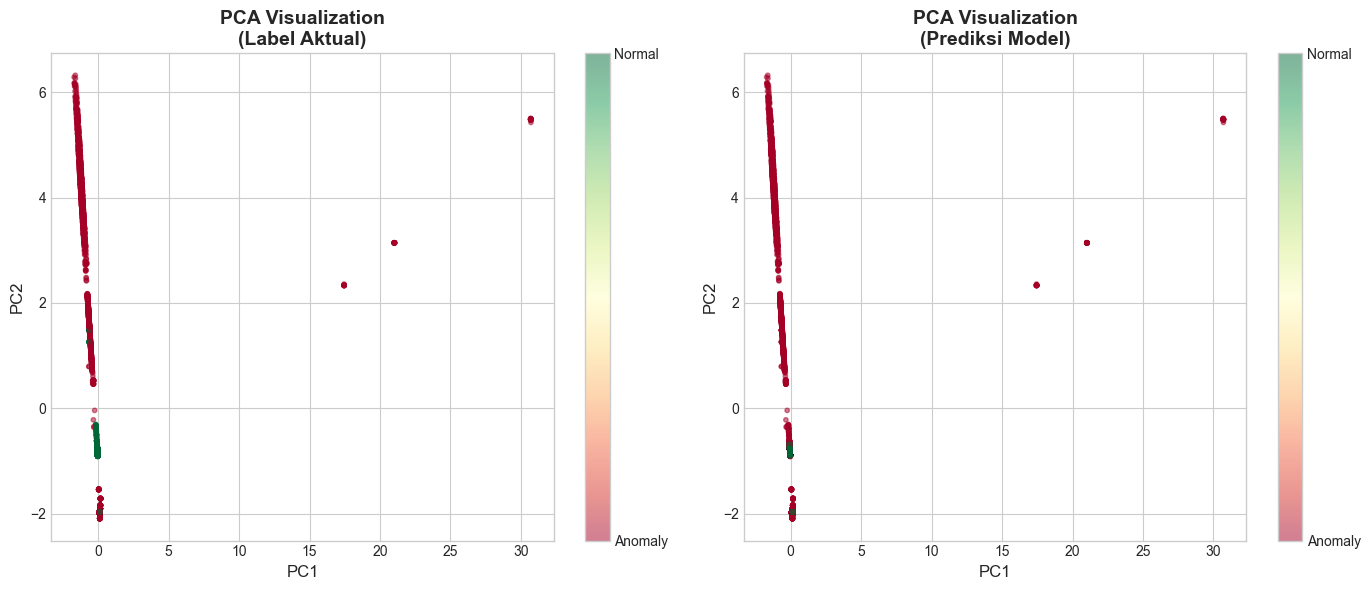

In [102]:
# Visualisasi 2: PCA 2D Scatter Plot
# Gunakan sample untuk visualisasi (agar tidak terlalu lambat)
sample_size = min(5000, len(X_test_scaled))
np.random.seed(42)
sample_idx = np.random.choice(len(X_test_scaled), sample_size, replace=False)

X_sample = X_test_scaled[sample_idx]
y_actual_sample = y_test_binary.values[sample_idx]
y_pred_sample = y_test_pred[sample_idx]
scores_sample = test_scores[sample_idx]

# Reduksi dimensi dengan PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sample)

print(f"📊 Variance explained by PCA: {pca.explained_variance_ratio_.sum()*100:.2f}%")

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Berdasarkan Label Aktual
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], 
                           c=y_actual_sample, cmap='RdYlGn', 
                           alpha=0.5, s=10)
axes[0].set_xlabel('PC1', fontsize=12)
axes[0].set_ylabel('PC2', fontsize=12)
axes[0].set_title('PCA Visualization\n(Label Aktual)', fontsize=14, fontweight='bold')
cbar1 = plt.colorbar(scatter1, ax=axes[0])
cbar1.set_ticks([-1, 1])
cbar1.set_ticklabels(['Anomaly', 'Normal'])

# Plot 2: Berdasarkan Prediksi
scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], 
                           c=y_pred_sample, cmap='RdYlGn', 
                           alpha=0.5, s=10)
axes[1].set_xlabel('PC1', fontsize=12)
axes[1].set_ylabel('PC2', fontsize=12)
axes[1].set_title('PCA Visualization\n(Prediksi Model)', fontsize=14, fontweight='bold')
cbar2 = plt.colorbar(scatter2, ax=axes[1])
cbar2.set_ticks([-1, 1])
cbar2.set_ticklabels(['Anomaly', 'Normal'])

plt.tight_layout()
plt.show()


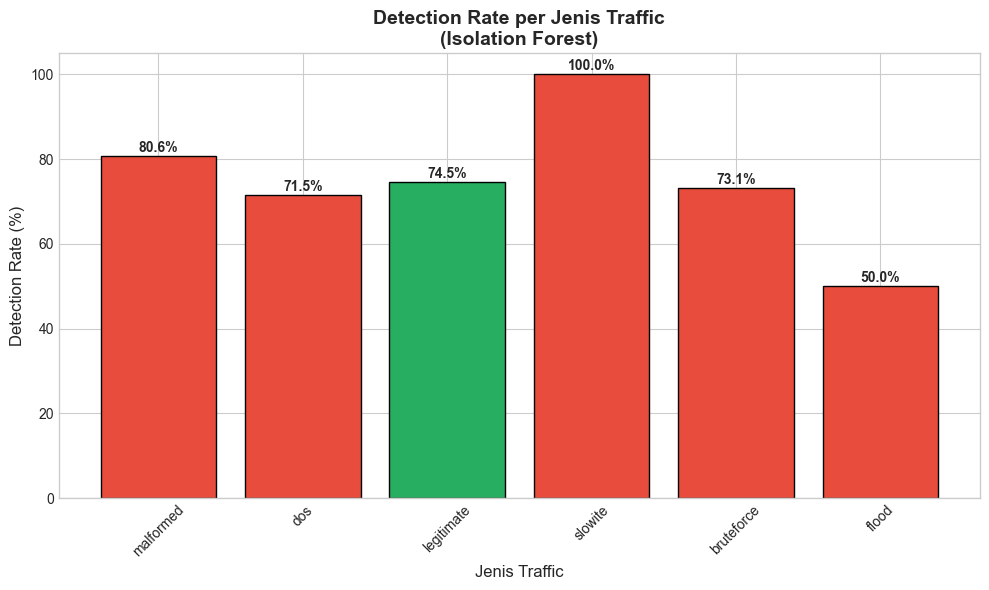


📊 Detail Detection Rate per Jenis Traffic:
   - malformed   : 80.63% terdeteksi sebagai Anomaly
   - dos         : 71.54% terdeteksi sebagai Anomaly
   - legitimate  : 74.52% terdeteksi sebagai Normal
   - slowite     : 100.00% terdeteksi sebagai Anomaly
   - bruteforce  : 73.09% terdeteksi sebagai Anomaly
   - flood       : 50.00% terdeteksi sebagai Anomaly


In [103]:
# Visualisasi 3: Deteksi per Jenis Serangan
attack_types = y_test_original.unique()
detection_rates = {}

for attack in attack_types:
    mask = y_test_original == attack
    if attack == 'legitimate':
        # Untuk legitimate, hitung berapa yang benar diprediksi normal
        correct = (y_test_pred[mask] == 1).sum()
    else:
        # Untuk serangan, hitung berapa yang benar diprediksi anomaly
        correct = (y_test_pred[mask] == -1).sum()
    total = mask.sum()
    detection_rates[attack] = (correct / total) * 100

# Plot
plt.figure(figsize=(10, 6))
colors = ['#27ae60' if k == 'legitimate' else '#e74c3c' for k in detection_rates.keys()]
bars = plt.bar(detection_rates.keys(), detection_rates.values(), color=colors, edgecolor='black')
plt.xlabel('Jenis Traffic', fontsize=12)
plt.ylabel('Detection Rate (%)', fontsize=12)
plt.title('Detection Rate per Jenis Traffic\n(Isolation Forest)', fontsize=14, fontweight='bold')
plt.ylim(0, 105)

# Tambahkan label nilai
for bar, val in zip(bars, detection_rates.values()):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{val:.1f}%', ha='center', fontweight='bold')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print detail
print("\n📊 Detail Detection Rate per Jenis Traffic:")
for attack, rate in detection_rates.items():
    status = "Normal" if attack == 'legitimate' else "Anomaly"
    print(f"   - {attack:12s}: {rate:.2f}% terdeteksi sebagai {status}")


## 9. Ringkasan


In [104]:
# Ringkasan Hasil
print("=" * 60)
print("📋 RINGKASAN DETEKSI ANOMALI MQTT DENGAN ISOLATION FOREST")
print("=" * 60)

print(f"\n📁 Dataset:")
print(f"   - Training samples: {len(X_train):,}")
print(f"   - Testing samples : {len(X_test):,}")
print(f"   - Jumlah fitur    : {X_train.shape[1]}")

print(f"\n⚙️  Model Parameters:")
print(f"   - n_estimators   : {iso_forest.n_estimators}")
print(f"   - contamination  : {contamination_rate:.4f}")
print(f"   - max_samples    : {iso_forest.max_samples}")

print(f"\n📈 Performa Model (Testing Set):")
print(f"   - Akurasi  : {accuracy*100:.2f}%")
print(f"   - Presisi  : {precision*100:.2f}%")
print(f"   - Recall   : {recall*100:.2f}%")
print(f"   - F1-Score : {f1*100:.2f}%")

print(f"\n🎯 Kelas Target:")
print(f"   - Normal  : legitimate")
print(f"   - Anomaly : dos, malformed, slowite, bruteforce")

print("\n" + "=" * 60)
print("✅ Analisis selesai!")
print("=" * 60)


📋 RINGKASAN DETEKSI ANOMALI MQTT DENGAN ISOLATION FOREST

📁 Dataset:
   - Training samples: 231,646
   - Testing samples : 99,290
   - Jumlah fitur    : 33

⚙️  Model Parameters:
   - n_estimators   : 100
   - contamination  : 0.5000
   - max_samples    : auto

📈 Performa Model (Testing Set):
   - Akurasi  : 74.15%
   - Presisi  : 74.33%
   - Recall   : 73.78%
   - F1-Score : 74.06%

🎯 Kelas Target:
   - Normal  : legitimate
   - Anomaly : dos, malformed, slowite, bruteforce

✅ Analisis selesai!
